# Data Exploration

This stage aims to be part of the designing the structure of data for modern MLOps practices.

# Data

- There are many NetCDF files sums to ~1GB.
- Spatial resolution is 92y to 109x with 15 minutes of temporal resolution.


#### Storing many files in NetCDF files are not efficient by **high costs** due to billing of the cloud services are mostly **per operation** for files.


##### 🎯 Why Convert to Zarr?

| Aspect | Many Small NetCDF Files | Single Large NetCDF | **Zarr (Recommended)** |
|--------|------------------------|---------------------|----------------------|
| **Cloud Cost** | ❌ Very High (many ops) | ⚠️ Medium | ✅ Low |
| **ML Performance** | ❌ Slow (many reads) | ⚠️ Limited parallel | ✅ Fast parallel |
| **Flexibility** | ✅ Good | ❌ Must load all | ✅ Excellent |
| **Compression** | ⚠️ Per file | ✅ Good | ✅ Excellent |
| **Cloud Native** | ❌ No | ❌ No | ✅ Yes |

#### Approximate cost calculation:


##### Cost Comparison (100GB dataset)

| Strategy | Storage/Month | Operations/Month | **Total/Month** |
|----------|--------------|------------------|-----------------|
| Many small NetCDF | $1.80 | $50-200 | **$52-202** |
| Single large NetCDF | $1.80 | $5-10 | **$7-12** |
| **Zarr (Recommended)** | **$1.80** | **$2-5** | **$4-7** |



- Data will be preprocessed
    - sza preprocessing
    - converting to diffrent format & zipping
    - structuring it


In [1]:
import xarray as xr
import matplotlib.pyplot as plt

from src.utils import (
    NetCDFToZarrConverter
)

raw_data_path = "../data/raw/seviri"

In [2]:
hrv_ds_example = xr.open_mfdataset(f"{raw_data_path}/hrv_lr2*.nc") 

In [3]:
hrv_ds_example

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 52928, y: 92, x: 109)
Coordinates:
    lat      (y, x) float64 80kB dask.array<chunksize=(92, 109), meta=np.ndarray>
    lon      (y, x) float64 80kB dask.array<chunksize=(92, 109), meta=np.ndarray>
  * time     (time) datetime64[ns] 423kB 2004-01-01T08:00:00 ... 2019-12-31T1...
Dimensions without coordinates: y, x
Data variables:
    hrv      (time, y, x) float64 4GB dask.array<chunksize=(333, 31, 37), meta=np.ndarray>

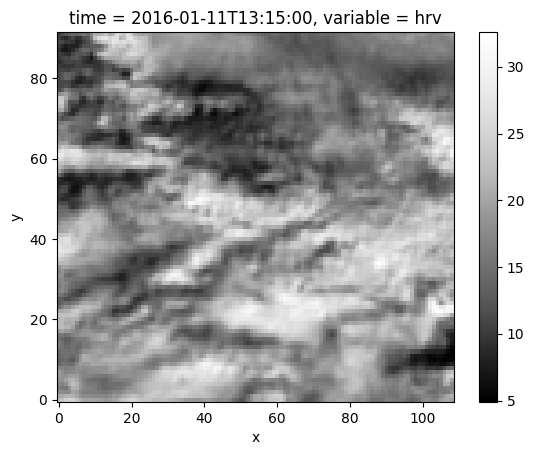

In [11]:
cmap = plt.get_cmap('Greys_r')

hrv_ds_example.isel(time=40000).to_array().plot(cmap=cmap)

In [5]:
# Scaling only performed for time dimension 
# 20MB per chunk is aimed

converter = NetCDFToZarrConverter()

chunk_analysis = converter.analyze_netcdf_files("../data/raw/seviri/hrv_lr2*.nc")

chunk_analysis["recommended_chunks"]

2026-01-29 17:11:29,427 - INFO - Analyzing NetCDF files matching: ../data/raw/seviri/hrv_lr2*.nc
2026-01-29 17:11:29,431 - INFO - Found 56 files
/home/plato/dl_cloudhole/dl_cloudhole/src/utils.py:74: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = dict(ds.dims)
2026-01-29 17:11:31,083 - INFO - Calculated chunk size: 19.97 MB | chunks={'time': 261, 'y': 92, 'x': 109}
2026-01-29 17:11:31,084 - INFO - Analysis complete: {'num_files': 56, 'files': ['hrv_lr200401.nc', 'hrv_lr200411.nc', 'hrv_lr200412.nc', 'hrv_lr200501.nc', 'hrv_lr200511.nc', 'hrv_lr200512.nc', 'hrv_lr200601.nc', 'hrv_lr200611.nc', 'hrv_lr200612.nc', 'hrv_lr200701.nc', 'hrv_lr200711.nc', 'hrv_lr200712.nc', 'hrv_lr200801.nc', 'hrv_lr200811.nc', 'hrv_lr200812.nc', 'hrv_lr200901.nc', 'hrv_lr200911.nc', 'hrv_lr200912.nc', 'h

{'time': 261, 'y': 92, 'x': 109}

In [6]:
from pathlib import Path
input_file_pattern="../data/raw/seviri/hrv_lr2*.nc"

files = sorted(Path().glob(input_file_pattern))

In [7]:
"""
- Issue:Segmentation fault (core dumped)
- Reason: parallel=True, chunks='auto' on xr.open_mfdataset
- Solution: set parallel false and chunks to None
"""

converter.convert_multiple_files_to_single_zarr(
    file_pattern = input_file_pattern,
    output_path = f"../data/processed/seviri/hrv_lr{files[0].as_posix()[-9:-5]}_{files[-1].as_posix()[-9:-5]}.zarr",
    custom_chunks = chunk_analysis["recommended_chunks"]
)

2026-01-29 17:07:18,625 - INFO - Converting multiple files to single Zarr: ../data/raw/seviri/hrv_lr2*.nc
2026-01-29 17:07:18,628 - INFO - Found 56 files to convert
2026-01-29 17:07:19,775 - INFO - Writing consolidated Zarr with chunks: {'time': 261, 'y': 92, 'x': 109}


3.955028712749481 GB dataset
Frozen({'time': (261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261, 261,

2026-01-29 17:07:49,690 - INFO - Successfully created consolidated Zarr at ../data/processed/seviri/hrv_lr2004_2019.zarr
2026-01-29 17:07:49,692 - INFO - 
2026-01-29 17:07:49,692 - INFO - Zarr Store Information: ../data/processed/seviri/hrv_lr2004_2019.zarr
2026-01-29 17:07:49,693 - INFO - ============================================================
2026-01-29 17:07:49,694 - INFO - /
 ├── hrv (52928, 92, 109) float64
 ├── lat (92, 109) float64
 ├── lon (92, 109) float64
 └── time (52928,) int64
2026-01-29 17:07:49,698 - INFO - ============================================================

